In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from PIL import Image
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array
import numpy as np
import pickle 
import cv2
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors 
from sklearn.preprocessing import LabelEncoder

In [2]:
# Load your CSV file
csv_file_path = 'data/product_list.csv'
df_csv = pd.read_csv(csv_file_path)

# Load your images
image_folder_path = 'data/DAM/'
image_data = []

for index, row in df_csv.iterrows():
    image_name = row['MMC']
    image_extension = '.jpeg'  # Update with the correct extension
    image_path = os.path.join(image_folder_path, image_name + image_extension)


    try:
        # Load the image using PIL (Python Imaging Library)
        img = Image.open(image_path)
        
        # Add the image data to the list
        image_data.append({'MMC': image_name, 'Product_BusinessUnitDesc': row['Product_BusinessUnitDesc'], 'Image': img})
    except Exception as e:
        # Print any exception that occurs
        print(f"Error loading image: {e}")

# Create a new DataFrame with the combined data
df_combined = pd.DataFrame(image_data)

# Display the combined DataFrame
# print(df_combined)


Error loading image: [Errno 2] No such file or directory: 'data/DAM/CD040112A0030000.jpeg'


In [3]:
augmentations = {
    'rotation_range': 40,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
    'fill_mode': 'nearest'
}

augmentation_datagen = ImageDataGenerator(**augmentations)

In [4]:

# Split data into training and testing sets
df_train, df_test = train_test_split(df_combined, test_size=0.2, random_state=42)

# Data Augmentation setup
augmentation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Preprocess and augment training images
X_train = np.stack(df_train['Image'].apply(lambda x: img_to_array(x.resize((224, 224)))))
# X_train = X_train / 255.0  # Normalize pixel values

# Preprocess test images (without augmentation)
X_test = np.stack(df_test['Image'].apply(lambda x: img_to_array(x.resize((224, 224)))))
# X_test = X_test / 255.0  # Normalize pixel values


label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_train['Product_BusinessUnitDesc'])
y_test = label_encoder.transform(df_test['Product_BusinessUnitDesc'])


X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))

In [5]:
X.shape, y.shape

((2766, 224, 224, 3), (2766,))

In [6]:
# Model building
# model = tf.keras.applications.MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
image_height, image_width = 224, 224

model = tf.keras.applications.efficientnet.EfficientNetB0(
    input_shape=(image_height, image_width, 3),
    include_top=False,
    weights='imagenet'
)

model.trainable = False  # Freeze pre-trained layers

# Add custom layers for classification
flatten_layer = tf.keras.layers.Flatten()
dense_layer = tf.keras.layers.Dense(128, activation='relu')
output_layer = tf.keras.layers.Dense(len(label_encoder.classes_), activation='softmax')

# Build the final model
classification_model = tf.keras.Sequential([
    model,
    flatten_layer,
    dense_layer,
    output_layer
])

# Compile the model
classification_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Training
history = classification_model.fit(
    augmentation_datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test)
)


# Access the loss values from the history object
loss_values = history.history['loss']

# Testing
test_loss, test_acc = classification_model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Save the model in the native Keras format
# classification_model.save('image_classification_model')

# To load the model later
# loaded_model = tf.keras.models.load_model('image_classification_model')




Epoch 1/10


70/70 [==============================] - 65s 813ms/step - loss: 1.2161 - accuracy: 0.7835 - val_loss: 0.3536 - val_accuracy: 0.8971
Epoch 2/10
70/70 [==============================] - 55s 788ms/step - loss: 0.3711 - accuracy: 0.8920 - val_loss: 0.2736 - val_accuracy: 0.9404
Epoch 3/10
70/70 [==============================] - 55s 779ms/step - loss: 0.3153 - accuracy: 0.9195 - val_loss: 0.2584 - val_accuracy: 0.9350
Epoch 4/10
70/70 [==============================] - 55s 782ms/step - loss: 0.3418 - accuracy: 0.9087 - val_loss: 0.3495 - val_accuracy: 0.9206
Epoch 5/10
70/70 [==============================] - 55s 787ms/step - loss: 0.2773 - accuracy: 0.9290 - val_loss: 0.2667 - val_accuracy: 0.9404
Epoch 6/10
70/70 [==============================] - 56s 801ms/step - loss: 0.2082 - accuracy: 0.9435 - val_loss: 0.3590 - val_accuracy: 0.9422
Epoch 7/10
70/70 [==============================] - 55s 789ms/step - loss: 0.2287 - accuracy: 0.9363 - val_loss: 0.2752 - val_accuracy: 0

In [7]:
loss_values = history.history['val_loss']
plt.plot(loss_values)
plt.title('Training Loss Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

18/18 [==============================] - 11s 479ms/step


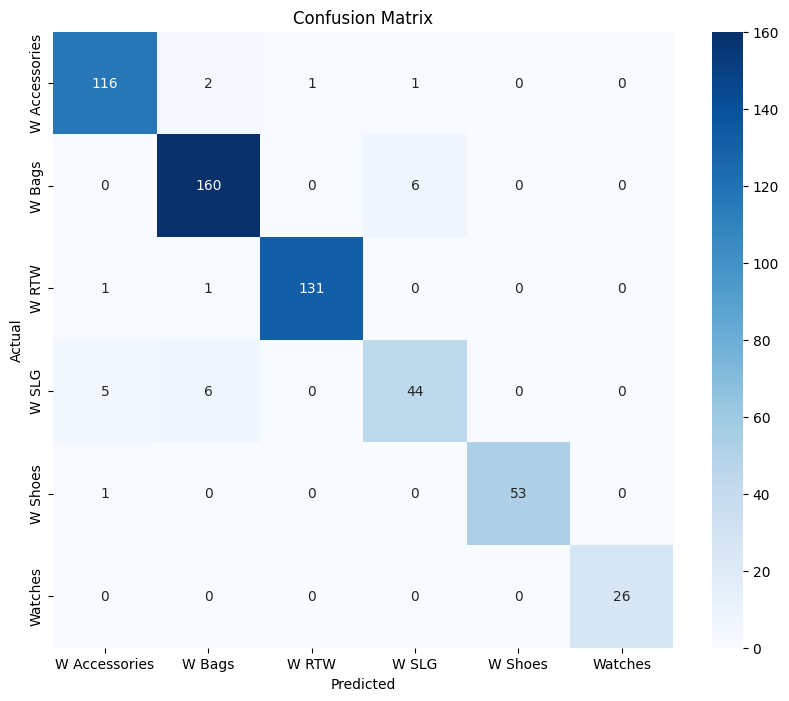

Classification Report:
                precision    recall  f1-score   support

W Accessories       0.94      0.97      0.95       120
       W Bags       0.95      0.96      0.96       166
        W RTW       0.99      0.98      0.99       133
        W SLG       0.86      0.80      0.83        55
      W Shoes       1.00      0.98      0.99        54
      Watches       1.00      1.00      1.00        26

     accuracy                           0.96       554
    macro avg       0.96      0.95      0.95       554
 weighted avg       0.96      0.96      0.96       554



In [8]:
# Testing
y_pred = classification_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = y_test

# Confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Classification report
class_report = classification_report(y_true_classes, y_pred_classes, target_names=label_encoder.classes_)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("Classification Report:\n", class_report)

In [9]:
history2 = classification_model.fit(augmentation_datagen.flow(X, y, batch_size=32), epochs=3)

Epoch 1/3
87/87 [==============================] - 58s 665ms/step - loss: 0.2094 - accuracy: 0.9519
Epoch 2/3
87/87 [==============================] - 64s 738ms/step - loss: 0.2348 - accuracy: 0.9501
Epoch 3/3
87/87 [==============================] - 62s 715ms/step - loss: 0.1511 - accuracy: 0.9552


In [10]:
with open('sl/masks.pickle', 'rb') as handle:
    final_masks = pickle.load(handle)

In [11]:
test_image_folder_path = 'data/test_image_headmind/'
test_image_data = []

L = os.listdir(test_image_folder_path)
for i in final_masks :
    img_float32 = np.float32(final_masks[i]['image'])
    img_float32[final_masks[i]['mask']<0.3] = 255
    X_img = cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)
    X_img = tf.image.resize(X_img, (224, 224))
    # X_img = X_img / 255.0
    test_image_data.append(np.array(X_img))

test_image_data = np.array(test_image_data)
y_pred = classification_model.predict(test_image_data)

3/3 [==============================] - 1s 439ms/step


In [12]:
classification_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 128)               8028288   
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 12078633 (46.08 MB)
Trainable params: 8029062 (30.63 MB)
Non-trainable params: 4049571 (15.45 MB)
_________________________________________________________________


In [13]:
y_pred = classification_model.predict(test_image_data)
classes = label_encoder.classes_

embedding_model = tf.keras.models.Model(classification_model.inputs, classification_model.get_layer('flatten').output)
y_embedding = embedding_model.predict(np.array(X))

87/87 [==============================] - 48s 521ms/step


In [14]:

# mask = (y>=0)
pca = PCA(n_components=4)

X_proj = pca.fit_transform(y_embedding)

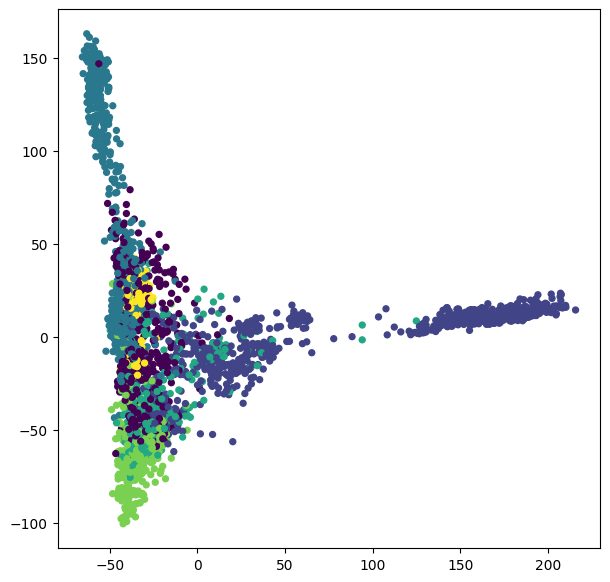

In [15]:

plt.figure(figsize=(7, 7))
plt.scatter(X_proj[:, 0], X_proj[:, 1], c=y, s=18)
plt.show()

In [16]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(projection='3d')

ax.scatter(X_proj[:, 0], X_proj[:, 1], X_proj[:, 2], c=y)
plt.show()

In [17]:
y_embedding_test = embedding_model.predict(test_image_data)

3/3 [==============================] - 1s 363ms/step


In [18]:
neighbors = []

for i in range(len(y_embedding_test)) : 
    
    nn = NearestNeighbors(n_neighbors=10)
    idx = np.argmax(y_pred[i])
    # print(idx)
    nn.fit(y_embedding[y==idx])
    neighbors.append(nn.kneighbors(np.array([y_embedding_test[i]]))[1][0])
    # print(nn.kneighbors(np.array([y_embedding_test[i]]))[1][0])
    # break
    
neighbors = np.array(neighbors)

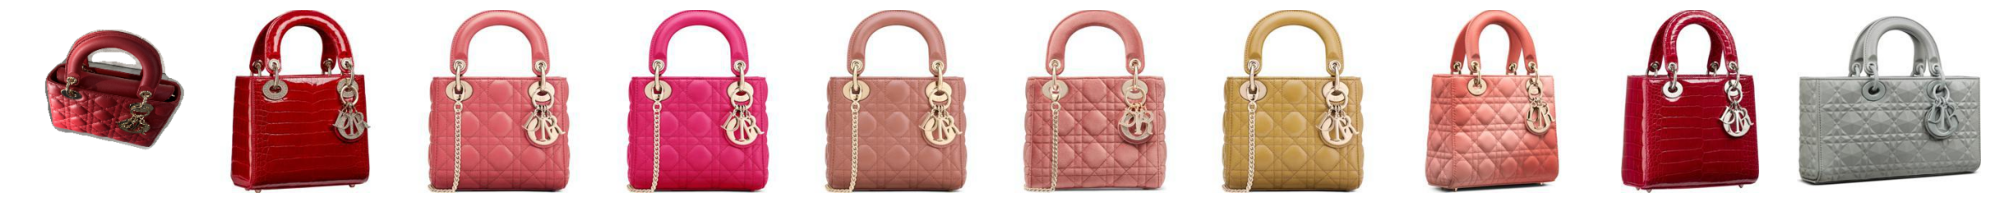

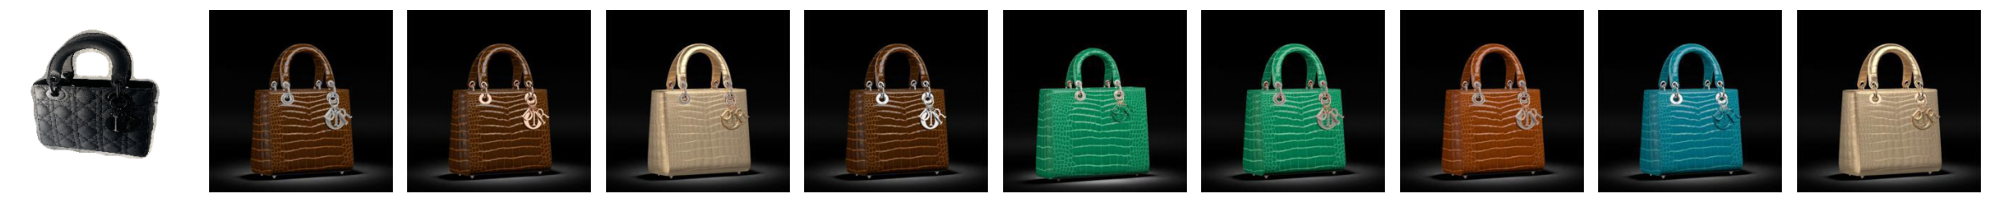

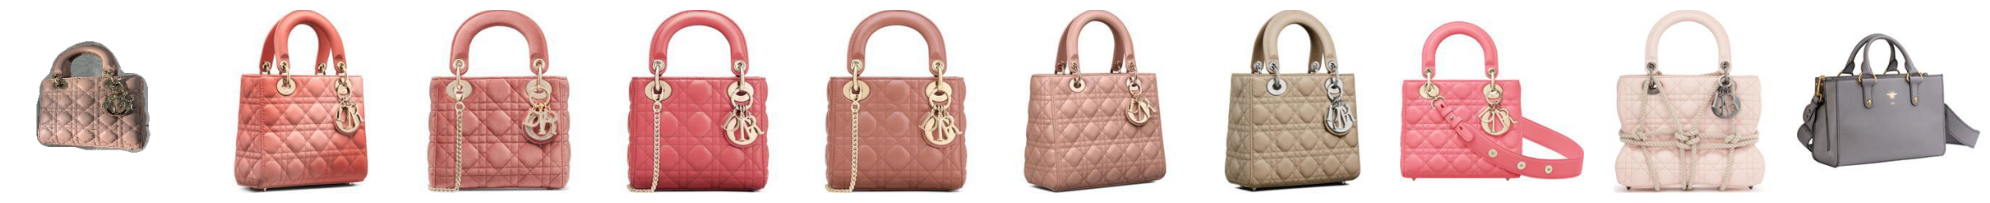

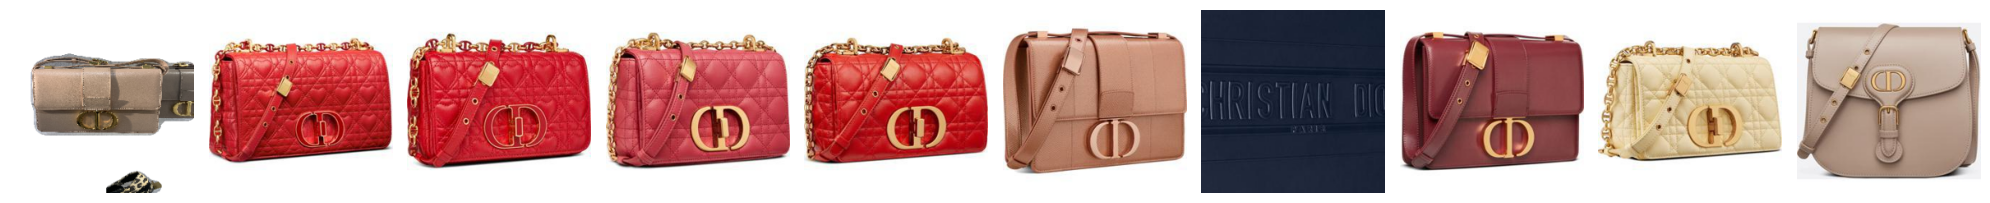

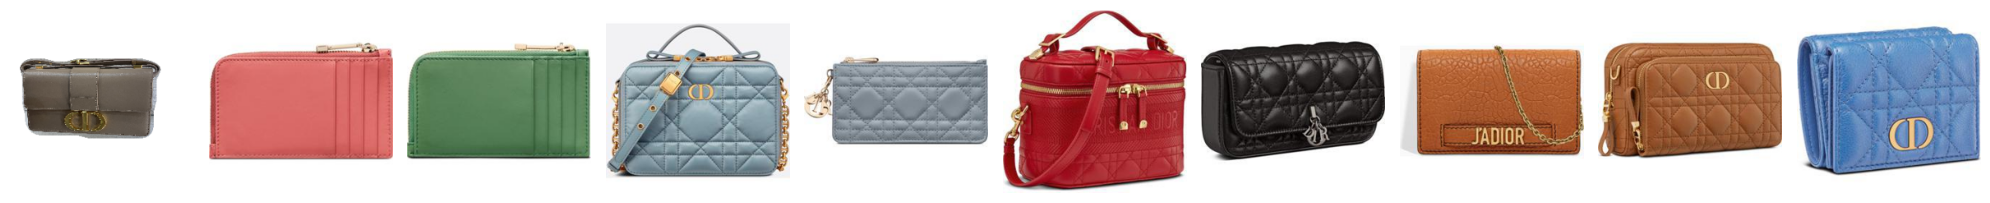

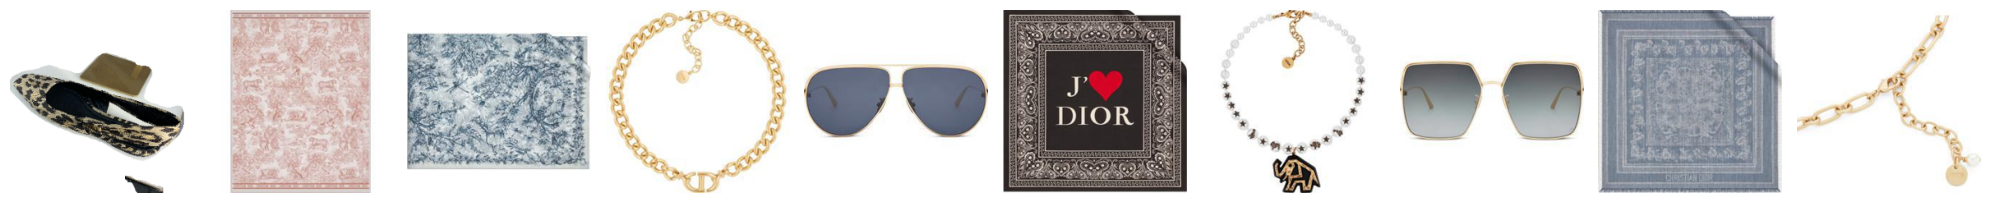

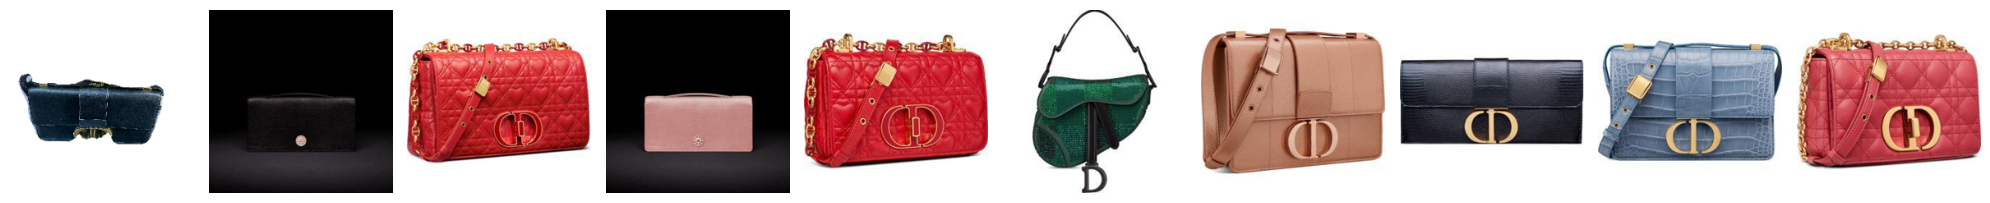

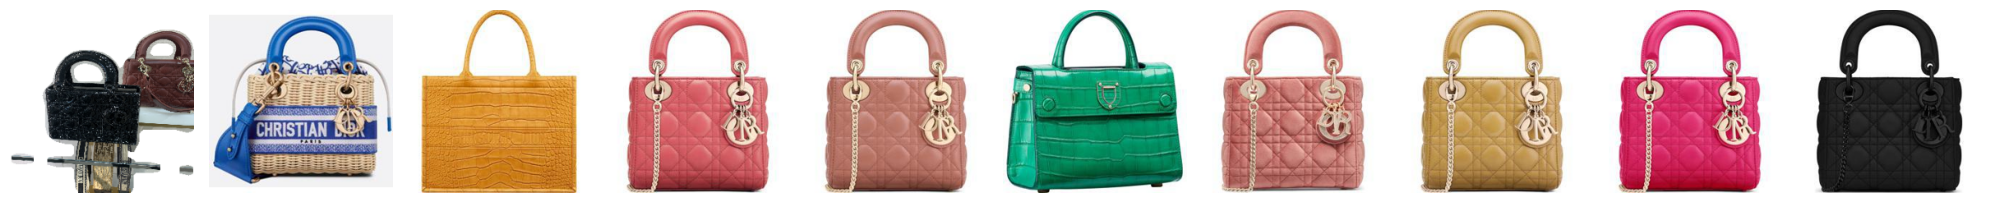

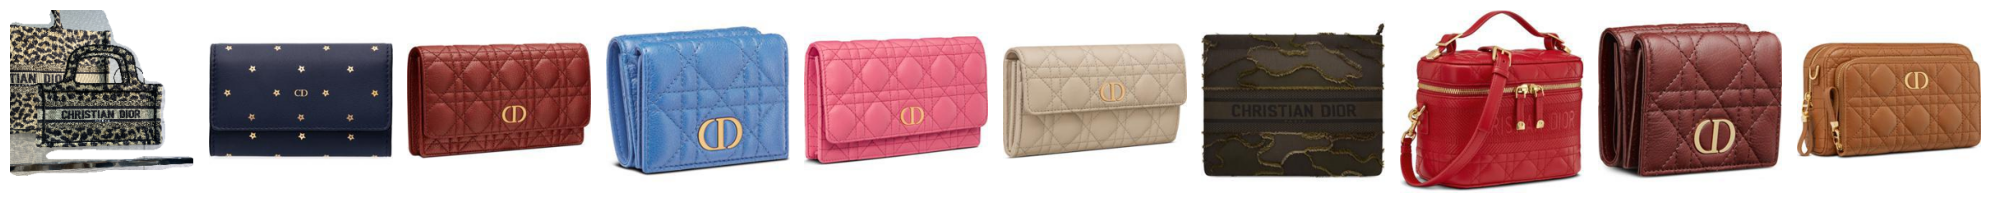

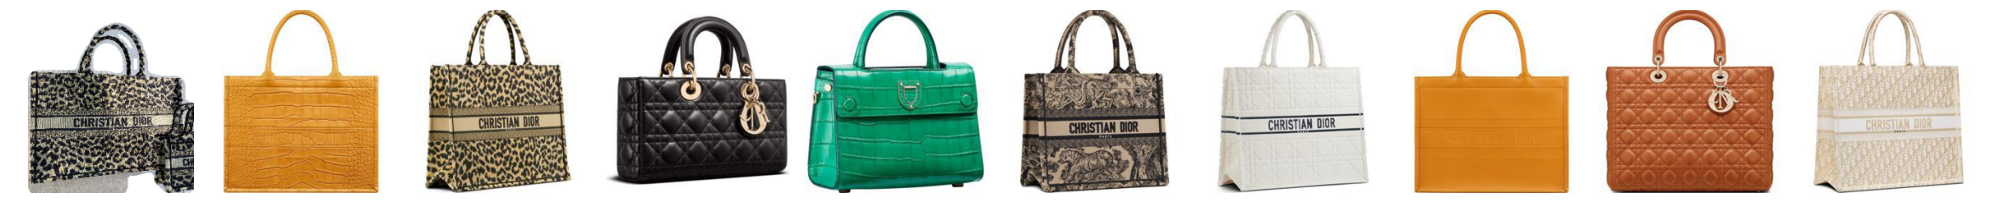

In [19]:
train_image_data = np.array(X)

for i in range(10) :
    fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20, 6))
    # fig.patch.set_visible(False)

    axes[0].imshow(test_image_data[i].astype(int))
    axes[0].axis('off')
    
    idx = np.argmax(y_pred[i])
    axes[0].set_ylabel(classes[idx])
    
    neighborhood = train_image_data[y==idx][neighbors[i, :]]

    for j in range(9) : 
        axes[j+1].imshow(neighborhood[j].astype(int))
        axes[j+1].axis('off')
    # Adjust layout to prevent clipping of titles and labels
    plt.tight_layout()

    # Show the plot
    plt.show()
    
    # print(neighborhood.shape)